In [282]:
'''
Data munging libraries

'''
import pandas as pd
import numpy as np
'''
Visualization Libraries

'''
import matplotlib.pyplot as plt
import seaborn as sns
'''
ML libraries

'''
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.model_selection import *;

# Process:
* Bring normal data for training 
* Apply gaussian noise
* create AE layers
* pass residuals to an Isolation Forest for one class classification

In [299]:
def create_df(file,setpoint1,setpoint2,usedate=False):
    """
    creates a dataframe from a csv file, add month and year fields and apply filtration
    Inputs: 
    file is csv filename
    setpoint1 and setpoint2 are filter values
    Output:
    Pandas dataframe
    
    """
    
    newTable=pd.read_csv(file,header=0,encoding="ISO-8859-2")
    engine_df=newTable[(newTable["Gross Power Output - KPI"]>setpoint1)&
                   (newTable['Comp Inlet Guide Vane Angle']>setpoint2)].reset_index(drop=True)
    if usedate==True:
        engine_df.Timestamp=pd.to_datetime(engine_df.Timestamp)
        engine_df["month"]=pd.DatetimeIndex(engine_df["Timestamp"]).month    
        engine_df["year"]=pd.DatetimeIndex(engine_df["Timestamp"]).year
    return engine_df

In [339]:
engine_df=create_df('train.csv',115,75)

In [342]:
X_all=engine_df[['Comp Inlet Temp','Comp Inlet Guide Vane Angle','Comb Firing Temp',  'Comp Disch Temp','Comp Disch Press',
                 'Fuel Gas Energy Flow', 'Gross Power Output - KPI','Turb Exh Press','Turb Exh Temp']].values

# Creating Training and Validation data sets

In [344]:
index=np.asarray([i for i in range(len(X_all))])

In [345]:
def split_data(xlist,splitarr,nsplit,testsize,random=2301):
    trainsplit  =  ShuffleSplit ( n_splits = nsplit ,  test_size = testsize ,  
                                           random_state = random )
    
    """
    n_splits is for number of splits
    test_size is % size from the entire population(between 0 and 1) for the test data set
    random_state this is used to generate repeatable results next time we run this code again
    """
    
    for  train_index ,  test_index  in  trainsplit . split ( splitarr):
        test1=1
        test2=2
                
    
    train_X=np.vstack([xlist[i] for i in train_index])
    test_X=np.vstack([xlist[i] for i in test_index])
        
   
    return train_X,test_X

In [346]:
train_X,val_X,=split_data(X_all,index,nsplit=1,testsize=0.2)

In [347]:
from keras.layers import Input, Dense,Dropout
from keras.models import Model
from keras import layers, backend, regularizers
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import adam

# Scaling data before using with NN

In [348]:
scalerx=StandardScaler()
scalerx.fit(train_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [349]:
train_norm=scalerx.transform(train_X)
val_norm=scalerx.transform(val_X)

In [350]:
feat_len=train_norm.shape[1]

# Adding Gaussian Noise to input

In [352]:
x_train_noisy = train_norm +0.5 * np.random.normal(loc=0.0, scale=1.0, size=train_norm.shape)
x_val_noisy = val_norm + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=val_norm.shape)

In [377]:
K.clear_session()

# Creating TensorFlow Graph

In [378]:
xin=Input(shape=(feat_len,))
encoded = Dense(50, activation='relu')(xin)
encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(50, activation='relu')(decoded)
decoded = Dense(feat_len)(decoded)


In [379]:
autoencoder = Model(xin, decoded)

In [380]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                500       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_5 (Dense)              (None, 50)                550       
__________

In [381]:
es=EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=20)

In [447]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train_noisy, train_norm,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, val_norm),callbacks=[es])

Train on 29426 samples, validate on 7357 samples
Epoch 1/500
29426/29426 [==============================] - 1s 19us/step - loss: 0.0598 - val_loss: 0.0606
Epoch 2/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0594 - val_loss: 0.0614
Epoch 3/500
29426/29426 [==============================] - 0s 15us/step - loss: 0.0595 - val_loss: 0.0609
Epoch 4/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0594 - val_loss: 0.0605
Epoch 5/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0593 - val_loss: 0.0610
Epoch 6/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0593 - val_loss: 0.0611
Epoch 7/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0597 - val_loss: 0.0609
Epoch 8/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0594 - val_loss: 0.0606
Epoch 9/500
29426/29426 [==============================] - 0s 14us/step - loss: 0.0595 - val_loss: 0.06

# Regenerate training data

In [383]:
train_val=np.vstack((train_norm, val_norm))
train_pred = autoencoder.predict(train_val)

# Predict test and new data

In [385]:
testX=create_df('test.csv',115,75)[['Comp Inlet Temp','Comp Inlet Guide Vane Angle','Comb Firing Temp',  
                                    'Comp Disch Temp','Comp Disch Press','Fuel Gas Energy Flow', 
                                    'Gross Power Output - KPI','Turb Exh Press','Turb Exh Temp']].values

In [386]:
def ae_predict(datain, scaler,ae_model):
    '''
    This function regenerates input signal using trained auto-econder
    input: 
    - sensor data
    - Fitted scaler transformer
    - fitted Autoencoder
    Output:
    - Predicted/reconstructed signal
    - Normalized input array
    '''
    datain_norm=scaler.transform(datain)
    pred=ae_model.predict(datain_norm)
    return pred, datain_norm

In [387]:
test_pred,test_norm=ae_predict(datain=testX,scaler=scalerx,ae_model=autoencoder)

In [388]:
newX=create_df('new.csv',115,75)[['Comp Inlet Temp','Comp Inlet Guide Vane Angle','Comb Firing Temp',  
                                    'Comp Disch Temp','Comp Disch Press','Fuel Gas Energy Flow', 
                                    'Gross Power Output - KPI','Turb Exh Press','Turb Exh Temp']].values

In [389]:
new_pred, new_norm=ae_predict(newX,scalerx,autoencoder)

# Plot Actual vs Reconstructed on test data and new data which contains anomalies

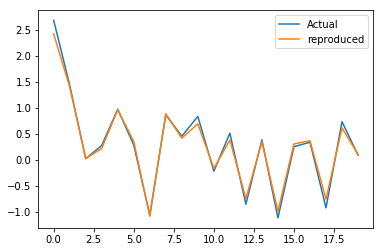

In [445]:
plt.plot(test_norm[-20:,4],label="Actual")
plt.plot(test_pred[-20:,4],label="reproduced")
plt.legend()
plt.show();

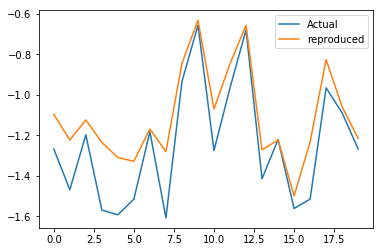

In [455]:
plt.plot(new_norm[2000:2020,4],label="Actual")
plt.plot(new_pred[2000:2020,4],label="reproduced")
plt.legend()
plt.show();

In [390]:
def outlier_train(arrayin,model=IsolationForest(contamination=0.005,n_jobs=-1,random_state=2301)):    
    '''
    This Function creates a residual data set and trains an isolation forest model on residuals
    input:
    - Tuple of both original array and reconstructed array
    - Isolation forest with default contamination of 0.005
    Output:
    - Fitted model
    
    '''
    
    resid=arrayin[0]-arrayin[1]
    oneclass=make_pipeline(StandardScaler(),model)
    oneclass=oneclass.fit(resid)
    return oneclass

In [391]:
oneclass_train=outlier_train((train_pred[:,2:],train_val[:,2:]))

In [392]:
def outlier_pred(arr_tuple,modelfit):
    
    '''
    This function performs prediction based on fitted model
    '''
    input_arr=arr_tuple[0]-arr_tuple[1]
    status=modelfit.predict(input_arr).reshape(-1,1)
    norm_arr=np.hstack((input_arr,status))
    norm_df=pd.DataFrame(norm_arr,columns=['Comb Firing Temp', 'Comp Disch Temp','Comp Disch Press','Fuel Gas Energy Flow', 
                                    'Gross Power Output - KPI','Turb Exh Press','Turb Exh Temp',"outlier_status"])
    return norm_df
    

In [409]:
def plot_outlier(data,model,x,y,hue,scatter=False):
    df=outlier_pred((data[0],data[1]),model)
    if scatter:
        sns.lmplot(x=df.index.values, y=y, data=df, size=8,hue=hue,
           fit_reg=False,scatter_kws={"s": 25});
    else:
        sns.lmplot(x=x, y=y, data=df, size=8,hue=hue,
           fit_reg=False,scatter_kws={"s": 25});

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


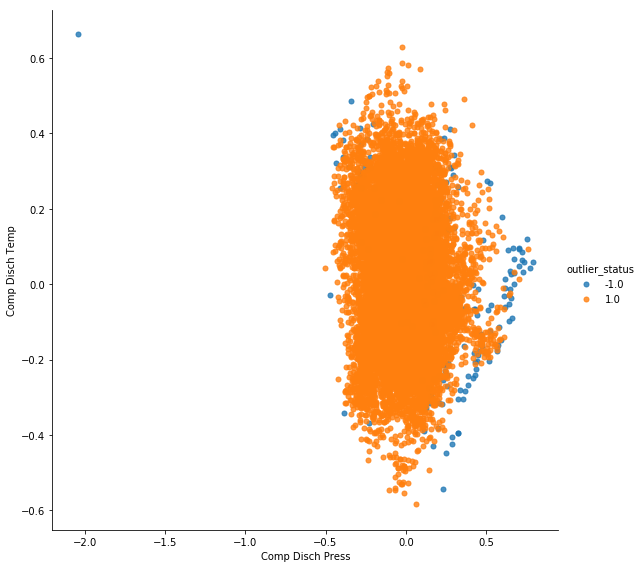

In [394]:
plot_outlier((train_pred[:,2:],train_val[:,2:]),oneclass_train,'Comp Disch Press', 'Comp Disch Temp',"outlier_status")

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


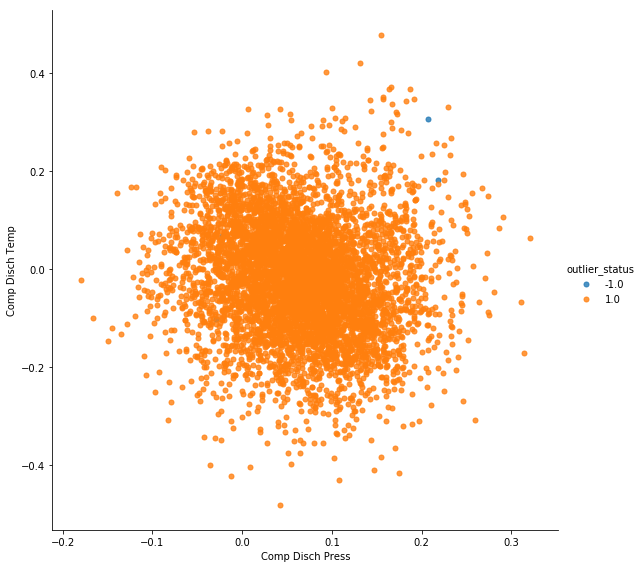

In [395]:
plot_outlier((test_pred[:,2:],test_norm[:,2:]),oneclass_train,'Comp Disch Press', 'Comp Disch Temp',"outlier_status")

# Plotting new data where anomalies eventually occured

In [438]:
df=outlier_pred((new_pred[:,2:],new_norm[:,2:]),oneclass_train)
df=df.reset_index()

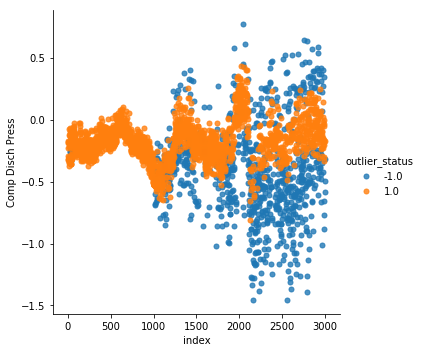

In [453]:
sns.lmplot(x='index', y='Comp Disch Press', data=df.iloc[:3000,:],hue="outlier_status",
           fit_reg=False,scatter_kws={"s": 25});